<a href="https://colab.research.google.com/github/gaioguy/EntropicTransferOperators/blob/main/Circle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entropic transfer operators
## Experiment 1: shift map on the circle

cf. [Junge, Matthes, Schmitzer: Entropic transfer operators](https://arxiv.org/abs/?)

## preparations

In [20]:
from google.colab import drive
drive.mount('/content/drive')
loc = "/content/drive/MyDrive/LagrangianOT/"  # needs to be adapted

import sys
sys.path.append(loc)
!pip install pykeops[colab] > install.log

from lib.header_notebook import *
import lib.SinkhornKeops as SinkhornKe
# import lib.SinkhornNP as Sinkhorn

%config InlineBackend.figure_format = 'retina'

π = np.pi

def plotSpectrum(eigvals, alpha=1):
    ax = plt.gca()
    ax.set_aspect('equal');
    cc = plt.Circle((0,0), 1, alpha=0.2)
    ax.add_artist(cc) 
    plt.scatter(eigvals.real, eigvals.imag, s=5, c="blue", alpha=alpha)
    plt.xlim(-1.05,1.05); plt.ylim(-1.05, 1.05)
    return ax 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Circle map

In [49]:
anglesX = np.random.rand(N)*2*π
anglesY = np.mod(anglesX + θ, 2*π)

np.array([np.cos(anglesX), np.sin(anglesX)]).transpose().shape

(1000, 2)

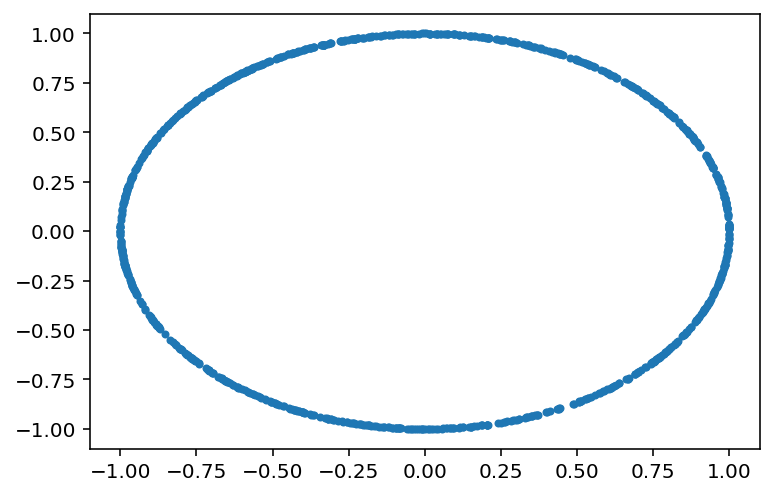

In [59]:
def getPoints(N, θ):
  # points on grid
  # anglesX=np.arange(N,dtype=np.float32)/N*2*np.pi
  # random points
  φX = np.random.rand(N)*2*π
  φY = np.mod(φX + θ, 2*π)

  X = np.zeros((N,2),dtype=np.float32)
  X[:,0], X[:,1] = np.cos(φX), np.sin(φX)
  Y = np.zeros((Ny,2),dtype=np.float32)
  Y[:,0], Y[:,1] = np.cos(φY), np.sin(φY)
  return X, Y

N = Ny = 1000
# θ = 2*np.pi/3.0   # irrational 
θ = 2               # rational
X, Y = getPoints(N, θ)
plt.plot(X[:,0], X[:,1], '.')

# initialze Sinkhorn solver

In [60]:
N, dim = X.shape
Ny = Y.shape[0]
print(N, Ny)

μX = np.ones(N,dtype=np.float32)
μX = μX/np.sum(μX)
μY = np.ones(Ny,dtype=np.float32)
μY = μY/np.sum(μY)

ε, εInit, errorGoal = 1E-5, 1.0, 1.0E-2
solver = SinkhornKe.TKeopsSinkhornSolverStandard(X, Y, μX, μY, errorGoal, eps=ε, epsInit = εInit,verbose=False)
solver.solve()

1000 1000


0

## eigenvalue asymptotics

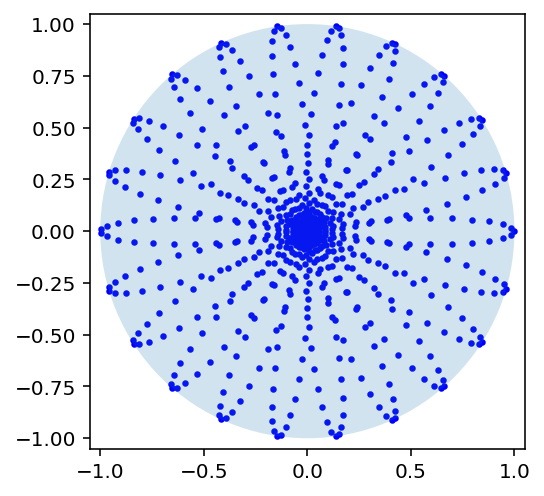

In [61]:
ε = 3e-6
θ = 1/π # 2*π/3.0
N2 = 500
λ = [ np.exp(-ε*π**2*abs(k)**2)*np.exp(-2*π*1j*k*θ) for k in range(-N2,N2) ]
plotSpectrum(np.array(λ))
plt.savefig(loc + "figures/circle/rat-asymptotic-eps="+str(ε)+".pdf")

## spectrum of Γ for particular ε

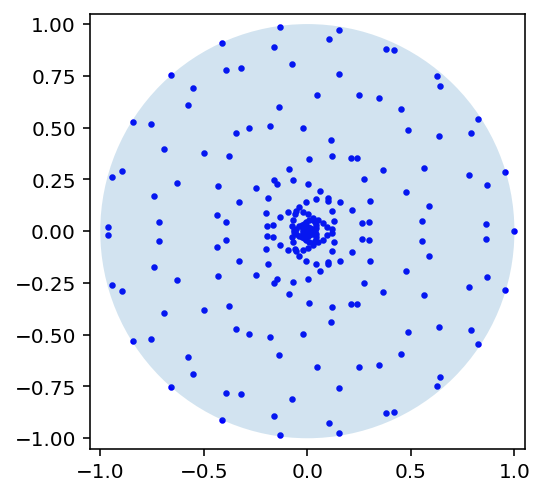

In [63]:
ε = 1e-3
solver.setRelEpsList(ε)
solver.solve()
Γ = solver.extractCoupling(thresh=1E-16,maxLen=1E7)
Γ.data[:] *= N
λ = eig(Γ.toarray())[0]
plotSpectrum(λ)
plt.savefig(loc + "figures/circle/rat-random-eps="+str(ε)+".pdf")

## histogram of spectra of Γ for different realizations of the point cloud X

IntProgress(value=0, max=10)

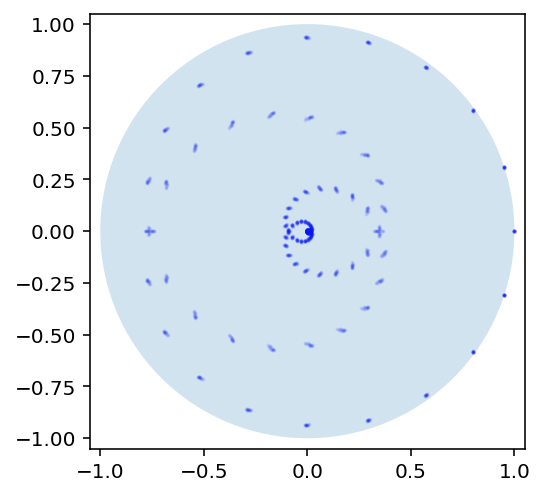

In [64]:
plotSpectrum(np.array([]))

ε = 1e-2
max_k = 10
f = IntProgress(min=0, max=max_k)   # display progress bar
display(f) 

for k in range(0, max_k):
  X, Y = getPoints(N, θ)
  solver = SinkhornKe.TKeopsSinkhornSolverStandard(X, Y, μX, μY, errorGoal, eps=ε, epsInit=εInit, verbose=False)
  solver.solve()
  Γ = solver.extractCoupling(thresh=1E-16,maxLen=1E7)
  Γ.data[:] *= N
  λ = eig(Γ.toarray())[0]
  plt.scatter(λ.real, λ.imag, marker='o', s=1, c="blue", alpha=0.1)
  f.value += 1

plt.savefig(loc + "figures/circle/rat_random_eps="+str(ε)+"_histogram.png", dpi=200)
plt.show()